## 共享单车用户数预测

利用美国某共享单车公司2011/2012年数据，训练和测试一个模型，并对模型的性能和预测能力进行测试。
原始数据包括该公司收集到与共享单车业务相关的17个特征。
原始数据已经经过处理，存储为csv格式。

## 1.导入必要工具包

In [58]:
import numpy as np #矩阵处理
import pandas as pd #数据处理

from sklearn.metrics import r2_score # 评价回归预测模型的性能

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt #画图
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder # 数据标准化

from scipy.sparse import hstack

# 图形出现在Notebook里而不是新窗口
%matplotlib inline


## 2.数据探索
见文件　CBdata.ipynb

In [59]:
### 2.1 读取数据

In [60]:
# dapath = '/media/wyb/work/AI-learning/ai/week-00/ML-Capital-Bikeshare/dataset/'  # 数据文件路径

cb = pd.read_csv('../dataset/day.csv')  # 以csv格式读取数据

# print "cb　data type is %s" % cb.dtypes  # 输出各字段数据类型

cb.head()  # 打印文件头部内容，查看各字段前五列数据值
# print cb.tail()  # 打印数据尾部五个数据值


# 读取样本数目、特征维数每个特征的类型、空值样本数目、数据类型
# cb.shape



,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## 2.2 数据准备

In [61]:
# 取出2011年数据作为训练数据,2012年作为测试数据
# train_data = cb[cb['yr'] == 0]

# test_data = cb[cb['yr'] ==1 ]
y = cb['cnt']

X = cb.drop(['dteday','instant','casual','registered','cnt'],axis=1)

# 训练数据与测试数据8/2分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# 从训练数据中获取输入特征X和输出特征Y
#y_train = y_train['cnt'].values

#　删除暂时无关特征
# X_train = X_train.drop(['dteday','instant','casual','registered'],axis=1)

# X_test = X_test.drop(['dteday','instant','casual','registered'],axis=1)

# columns = X_test.columns

## 2.3 数据预处理/特征工程

### 2.3.1　数据预处理

In [63]:
OneHotEnc = OneHotEncoder()
mn_x = MinMaxScaler()

# 对训练数据中输入特征x中类别变量进行OneHotEncoder处理
x_train_cat = OneHotEnc.fit_transform(X_train[['season','mnth','holiday','weekday','workingday']])

#　数据值变量继续预处理
x_train_num = mn_x.fit_transform(X_train[['temp','atemp','hum','windspeed']])

# 将变换后的变量合到一起
x_train = hstack((x_train_cat, x_train_num))

# y_train = train_data['cnt'].values

In [64]:
# 对测试数据预处理
x_test_cat = OneHotEnc.transform(X_test[['season','mnth','holiday','weekday','workingday']])
x_test_num = mn_x.transform(X_test[['temp','atemp','hum','windspeed']])
x_test = hstack((x_test_cat, x_test_num))

# y_test = test_data['cnt'].values

### 3.确定模型类型
#### 3.1 尝试缺省参数的线性回归

In [65]:
#　线性回归
from sklearn.linear_model import LinearRegression

#使用默认配置初始化
lr = LinearRegression()

# 训练模型参数
lr.fit(x_train, y_train)

#分别在训练集与测试集预测
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)

print y_test_pred_lr.shape
print y_test

# 查看各特征权重，权重绝对值大小为该特征重要程度
# fs = pd.DataFrame({'columns':list(), "coef":list((lr.coef_.T))})
# fs.sort_values(by=['coef'], ascending=False)
# y_test_pred_lr

(147,)
703    6606
33     1550
300    3747
456    6041
633    7538
557    7264
39     1605
356    2209
559    7499
514    5743
729    1796
355    3068
164    4891
697    5260
66     2133
78     2471
72     2046
643    8156
181    5362
380    2298
606    7697
545    5463
467    5409
65     1872
54     1807
235    5130
81     2121
632    7436
404    3830
717    5557
       ... 
369    3272
196    5923
375    2177
468    6398
319    1817
76     3239
2      1349
331    3867
690    5146
199    4541
314    3368
60     2134
568    7410
302    3331
306    3974
683    5495
711    5319
234    5895
90     2227
473    4367
469    7460
69     1977
212    4266
131    4864
44     1913
70     2132
192    4258
328    2792
165    5180
135    3958
Name: cnt, Length: 147, dtype: int64


#### 3.1.1 模型评价

In [66]:
# 使用r2_score评价模型在测试及和训练集上的性能，并输出评估结果
# 测试集
print 'The r2 score of LinearRegression on test is',r2_score(y_test, y_test_pred_lr)

# 训练集
print 'The r2 score of LinearRegression on train is',r2_score(y_train, y_train_pred_lr)

The r2 score of LinearRegression on test is 0.511853760044
The r2 score of LinearRegression on train is 0.573943964507


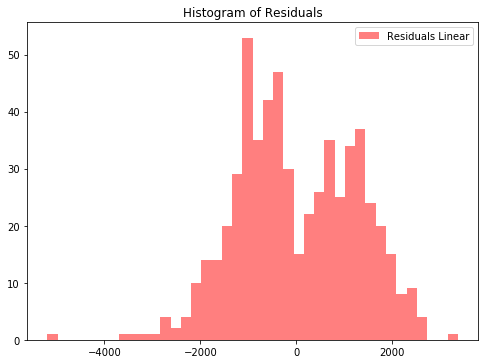

In [67]:
# 在训练集上观测预测残差分布
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(y_train - y_train_pred_lr, bins=40, label="Residuals Linear", color='red', alpha=.5)
ax.set_title("Histogram of Residuals")
ax.legend(loc='best')


## 4.岭回归，对正则参数lambda (scikit learn 中为alpha)调优

In [68]:
from sklearn.linear_model import RidgeCV

#设置超参数范围
alphas = [0.01, 0.1, 1, 10, 100]

#生成一个RidgeCV实例
ridge = RidgeCV(alphas = alphas)

In [69]:
# 模型训练
ridge.fit(x_train, y_train)

RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [70]:
# 预测
y_test_pred_cv = ridge.predict(x_test)
y_train_pred_cv = ridge.predict(x_train)

In [71]:
# 评估，使用r2_score评价模型在测试集和训练集上的性能
print (('the r2 score of RidgeCV on test is '), r2_score(y_test, y_test_pred_cv))
print (('the r2 score of RidgeCV on train is '), r2_score(y_train, y_train_pred_lr))

('the r2 score of RidgeCV on test is ', 0.51718721391135358)
('the r2 score of RidgeCV on train is ', 0.57394396450741625)
